# Alternating basis gates

This notebook serves to compare the performance of using different basis gates in the partitioning process.

More specifically, there are different options available to achieve a desired gate set in the final circuit. 

## Pre-partitioning transpilation

One option is to choose the desired gate set from the start, and build the graphical circuit based on this. 
*Advantages*:
- Optimisation can be performed globally across the circuit, since there will be no immutable entanglement blocks separating different sections of the circuit. This could result in lower circuit depth.

*Disadvantages*:
- Using $CX$ or $CZ$ gates instead of $CP$ gates may increase the number of two-qubit gates, and likely the number of e-bits required too.
- Decomposing $U$ gates will result in deep circuits corresponding to larger problem instances for partitioning.

## Post-partitioning transpilation

Alternatively, we partition using the general $[U, CP]$ gate set, and then only transpile the rest of the circuit after we have partitioned and inserted our teleportation instructions.

*Advantages*:
- The temporal hypergraph framework is designed to work with the $U$ and $CP$ gate set, since this allows us to compress many gates into one, so reduces the size of the partitioning problem. 
- $CP$ gates are symmetric and so give greater potential for gate grouping - this usually results in lower e-bit costs, which is the main target of the optimisation.
- Since we will likely have to recompile for intra-QPU routing anyway, we can combine these together.

*Disadvantages*:
- When transpiling after partitioning, we are more restricted since entanglement generation blocks must be made immutable to keep within our QPU constraints. This often means our sub-circuits are deeper than they could be (though this is negated if entanglement generation and distribution dominates the run time).
- Potentially avoid an extra transpilation step.

We will compare these on a couple of examples.

## Pre-partitioning transpilation

In [56]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork, all_to_all
import numpy as np

num_qubits = 32

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QFT(num_qubits, do_swaps=False)


num_partitions = 4 # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list


# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)


basis_gates = ['cp', 'u']


circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

# circuit.draw('mpl', fold = 100, style='bw')

Number of qubits in circuit 32
Circuit depth: 32


In [57]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
from disqco.parti.FM.FM_methods import set_initial_partition_assignment

depth = circuit.depth() # Get the depth of the circuit

graph = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True)

assignment = set_initial_partition_assignment(graph, quantum_network)


If you want to look at the graph, you can use the following code to draw it. It's just something that's been thrown together so doesn't work very well and you have to play around with the scale but it can be useful to see what's going on.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


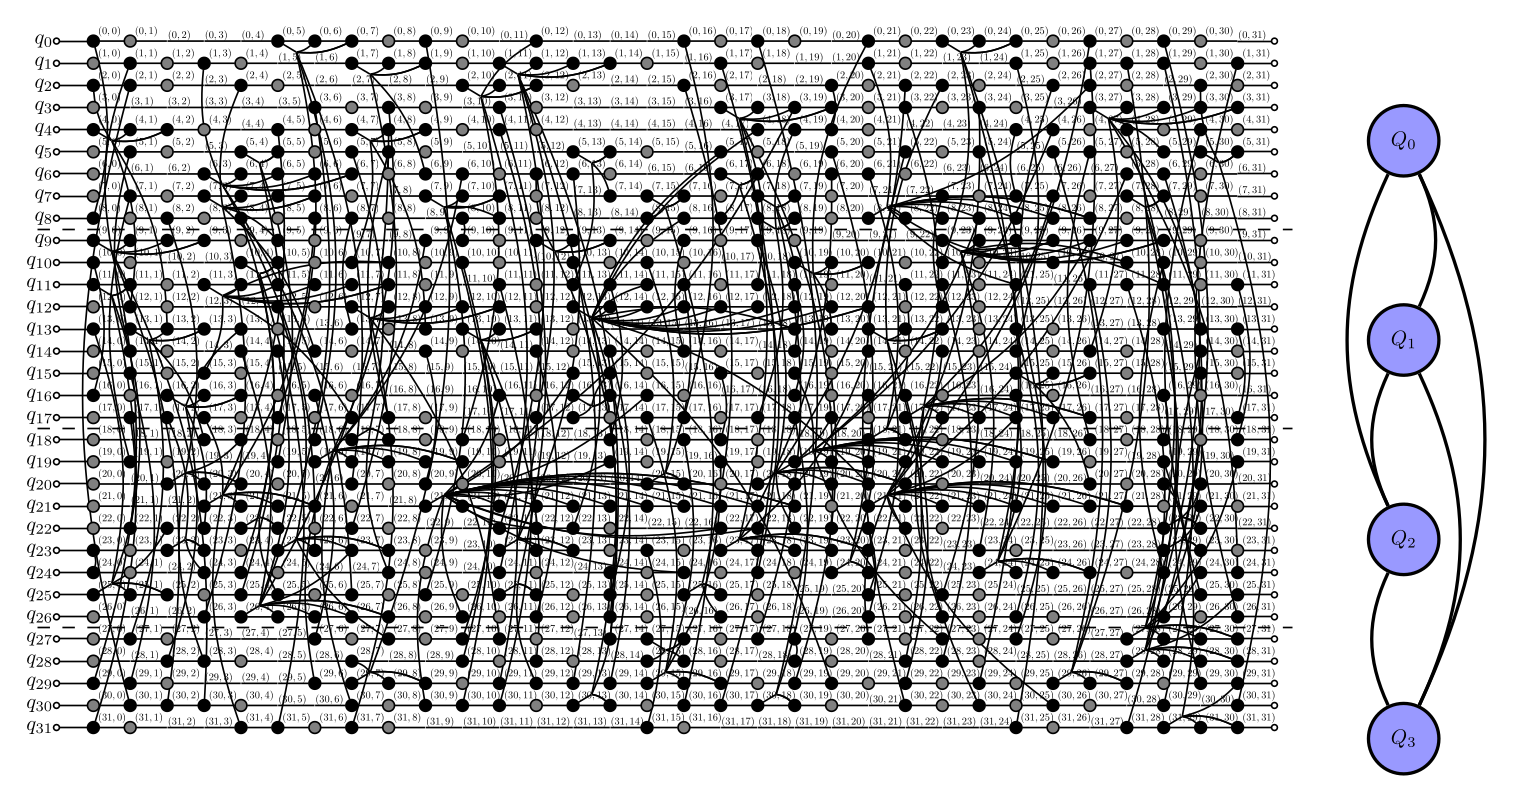

In [58]:
%load_ext jupyter_tikz

if num_qubits <= 32 and depth <= 100:
    fig = graph.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='tikz')
    display(fig)
elif num_qubits <= 64 and depth <= 128:
    fig = graph.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='mpl')
    display(fig)

In [59]:
from disqco.parti.FM.fiduccia import FiducciaMattheyses
import numpy as np
import time

start = time.time()
partitioner = FiducciaMattheyses(circuit, quantum_network, assignment, hypergraph=graph)
results = partitioner.multilevel_partition()
end = time.time()

print(f'Time taken for MLFM: {end - start} seconds')

final_cost_CP_U = results['best_cost']
final_assignment_CP_U = results['best_assignment']


Time taken for MLFM: 0.5473837852478027 seconds


In [60]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        network=quantum_network,
                                        partition_assignment=final_assignment_CP_U)

extracted_circuit = extractor.extract_partitioned_circuit()

print(f'Number of EPR pairs in partitioned circuit: {extracted_circuit.count_ops()["EPR"]}')

Number of EPR pairs in partitioned circuit: 93


In [61]:
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.transpiler import PassManager
from qiskit.synthesis import SolovayKitaevDecomposition, generate_basic_approximations
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit.library import UGate
from qiskit.quantum_info import Operator

def transpile_partitioned_circuit(circuit, basis_gates_unary, basis_gates_binary, approx_depth=2, skd_degree=2):
    """Transpile the partitioned circuit to the specified basis gates."""
    basic_approx = generate_basic_approximations(basis_gates=basis_gates_unary, depth=approx_depth, )
    skd = SolovayKitaevDecomposition(basic_approximations=basic_approx)

    final_circuit = transpile(circuit, basis_gates=['u'] + basis_gates_binary + ['EPR'])
    dag = circuit_to_dag(final_circuit)

    for node in list(dag.op_nodes(op=UGate)):
        matrix = Operator(node.op).to_matrix()
        # Normalize the matrix to ensure it is a valid quantum gate
        matrix /= np.sqrt(np.linalg.det(matrix))
        replacement = skd.run(matrix, recursion_degree=skd_degree)
        replacement_dag = circuit_to_dag(replacement)
        dag.substitute_node_with_dag(node, replacement_dag)
    
    final_circuit = dag_to_circuit(dag)
    return final_circuit

basis_gates_unary = ['h', 's', 't', 'tdg']
basis_gates_binary = ['cx']
clifford_T = basis_gates_unary + basis_gates_binary

In [62]:
final_circuit_U_CP_EPR = transpile(extracted_circuit, basis_gates=basis_gates + ['EPR'])

final_circuit = transpile_partitioned_circuit(final_circuit_U_CP_EPR, basis_gates_unary=basis_gates_unary, basis_gates_binary=basis_gates_binary)

print(f'Final circuit depth after post-partitioning transpilation: {final_circuit.depth()}')

print("Number of EPR pairs in partitioned circuit: ", final_circuit_U_CP_EPR.count_ops().get('EPR', 0))

# final_circuit.draw('mpl', fold=100, style='bw')








Final circuit depth after post-partitioning transpilation: 1734
Number of EPR pairs in partitioned circuit:  93


## Pre-partitioning tranpsilation

Compare this with building our graph from a pre-transpiled circuit into the Clifford + T basis. Nodes representing target qubits are shown as white, to highlight the asymmetry of these edges. We expect to see a much larger graph than previously.

In [63]:
circuit_clifford = transpile_partitioned_circuit(circuit, basis_gates_unary=basis_gates_unary, basis_gates_binary=basis_gates_binary)
graph = QuantumCircuitHyperGraph(circuit_clifford, group_gates=True, anti_diag=True, map_circuit=True)

assignment = set_initial_partition_assignment(graph, quantum_network)

if graph.num_qubits <= 32 and graph.depth <= 100:
    fig = graph.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='tikz')   
    display(fig)
elif graph.num_qubits <= 64 and graph.depth <= 128:
    fig = graph.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='mpl')
    display(fig)

In [64]:

partitioner = FiducciaMattheyses(circuit_clifford, quantum_network, assignment, hypergraph=graph)

results = partitioner.multilevel_partition(log=True)


extractor = PartitionedCircuitExtractor(graph=graph,
                                        network=quantum_network,
                                        partition_assignment=results['best_assignment'])


final_circuit = extractor.extract_partitioned_circuit()

final_circuit = transpile(final_circuit, basis_gates = clifford_T + ['EPR'])


depth = final_circuit.depth()

print(f'Final circuit depth after partitioning: {depth}')

print(f'Number of EPR pairs in partitioned circuit: {final_circuit.count_ops()["EPR"]}')



Initial cost: 169
All passes complete.
Final cost: 125
Initial cost: 125
All passes complete.
Final cost: 117
Initial cost: 117
All passes complete.
Final cost: 111
Initial cost: 111
All passes complete.
Final cost: 110
Initial cost: 110
All passes complete.
Final cost: 109
Initial cost: 109
All passes complete.
Final cost: 109
Initial cost: 109
All passes complete.
Final cost: 109
Initial cost: 109
All passes complete.
Final cost: 109
Initial cost: 109
All passes complete.
Final cost: 109
Final circuit depth after partitioning: 1157
Number of EPR pairs in partitioned circuit: 112


In this case, we see that the final circuit with post-partitioning transpilation is deeper but has fewer e-bits. If e-bit generation time is very slow this should be preferred. However, if we consider e-bit generation as simply another gate in the circuit, then we should prefer the version which transpiles to the required gate set first.